Hi!

This notebooks presents a guide for autoencoding songs withlinear and nonlinear compression methods, namely PCA, NMF and Single-song autoencoders.

It presents a simple example (Come Together, from The Beatles), and present results on the Cosine autosimilarity of the Nonnegative Log Mel spectrogram.

Feel free to play with this code! (like changing the song, the parameters, digging into the code, etc)

# Imports

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for reading signals
import soundfile as sf

# Pytorch, for neural networks
import torch

# Module to handle annotations for MIR files
import mirdata

Now, let's import the code we need. It's organized in modules, which should group "coherent" codes in themselves.

In [2]:
# Module encapsulating the computation of features from the signal
import barmuscomp.model.features as features

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import as_seg.data_manipulation as dm

# Module to process the input in barwise features
import as_seg.barwise_input as bi

# Module containing our algorithm used for computing the autosimilarity
import as_seg.autosimilarity_computation as as_comp

# Module containing our algorithm used for segmenting the autosimilarity
import as_seg.CBM_algorithm as CBM

# Module encapsulating Low-rank approximations (namely NTD, PCA and NMF)
import barmuscomp.lra as lra

# Module defining our neural network (CNN AutoEncoder)
import barmuscomp.ae as ae

# Module for data manipulation related to neural networks
import barmuscomp.ae_utils as ae_utils

# Plotting module
from barmuscomp.model.current_plot import *

# Loading the song, its annotations, and preparing it

Now, let's load the song (as a wav).

If you want to test in our example (Come Together, from the Beatles), you'll need to load the wav from your PC, but the rest of the data (like the annotations) will be downloaded automatically thanks to the package `mirdata`!

In that case, you need to modify the variable `path_to_beatles_dataset`, specifying where you want Betales annotation to be downloaded, and place the wav "01_-\_Come_Together.wav" in the folder "audio/11_-\_Abbey_Road/".

If you want to test on your own example, you'll need to change the variable `song_path`, and load manually your annotations (or no annotation at all if you don't need to test on the segmentation task and just visualize results).

In [3]:
path_to_beatles_dataset = 'C:/Users/amarmore/this_folder/Beatles dataset/'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

song_path = come_together.audio_path

INFO: Downloading ['annotations'] to C:/Users/amarmore/this_folder/Beatles dataset/
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: C:/Users/amarmore/this_folder/Beatles dataset/annotations\The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to C:/Users/amarmore/this_folder/Beatles dataset/



Loading the song as signal, and estimating bars of this song (using the `madmom` external library).

In [4]:
the_signal, sampling_rate = sf.read(song_path)
bars = dm.get_bars_from_audio(song_path)

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\neural_net\lib\site-packages\madmom\io\audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


# Barwise Compression

Now, let's compress the different bars of this song and evaluate results.

In [5]:
dc = 24 # Dimension of compression

## Compute the feature representation

In [6]:
hop_length = 32 # Oversampling the spectrogram, to select frames which will be equally-spaced barwise.
subdivision_bars = 96 # The number of time samples to consider in each bar.

nnlms = features.get_spectrogram(the_signal, sampling_rate, "nn_log_mel_grill", hop_length = hop_length)
freq_len = nnlms.shape[0]

## Baseline: autosimilarity of uncompressed representaiton

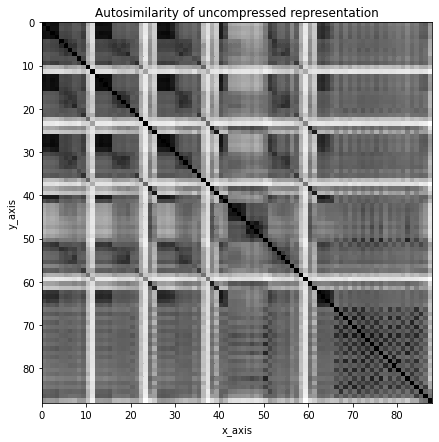

In [7]:
barwise_TF_matrix = bi.barwise_TF_matrix(nnlms, bars, hop_length/sampling_rate, subdivision_bars)
barwise_TF_autosimilarity = as_comp.get_cosine_autosimilarity(barwise_TF_matrix)
plot_me_this_spectrogram(barwise_TF_autosimilarity, title = "Autosimilarity of uncompressed representation")

In [8]:
segments_barwise_tf = CBM.compute_cbm(barwise_TF_autosimilarity, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_barwise_tf_in_time = dm.segments_from_bar_to_time(segments_barwise_tf, bars)

score_barwise_tf_zero_five = dm.compute_score_of_segmentation(references_segments, segments_barwise_tf_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_barwise_tf_zero_five[0]}, Recall {score_barwise_tf_zero_five[1]}, F measure {score_barwise_tf_zero_five[2]}")
score_barwise_tf_three = dm.compute_score_of_segmentation(references_segments, segments_barwise_tf_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_barwise_tf_three[0]}, Recall {score_barwise_tf_three[1]}, F measure {score_barwise_tf_three[2]}")

Score with 0.5 second tolerance: Precision 0.42857142857142855, Recall 0.5, F measure 0.4615384615384615
Score with 3 seconds tolerance: Precision 0.42857142857142855, Recall 0.5, F measure 0.4615384615384615


## NTD (Euclidean norm)

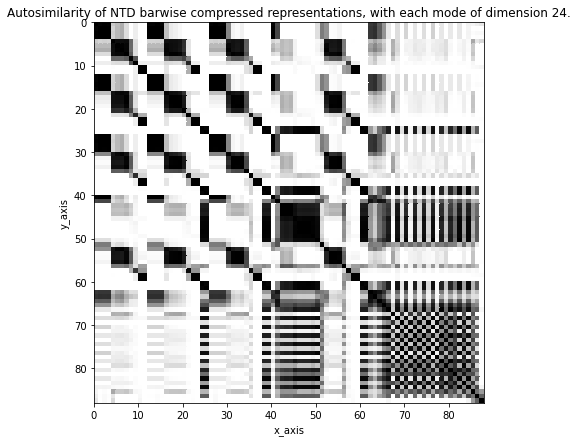

In [9]:
ntd_projection = lra.get_ntd_projection(nnlms, [dc, dc, dc], bars, beta = 2, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)
# See the tutorial dedicated to NTD for more details.

autosimilarity_ntd = as_comp.get_cosine_autosimilarity(ntd_projection)
plot_me_this_spectrogram(autosimilarity_ntd, title = f"Autosimilarity of NTD barwise compressed representations, with each mode of dimension {dc}.")

In [10]:
segments_ntd = CBM.compute_cbm(autosimilarity_ntd, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_ntd_in_time = dm.segments_from_bar_to_time(segments_ntd, bars)

score_ntd_zero_five = dm.compute_score_of_segmentation(references_segments, segments_ntd_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_ntd_zero_five[0]}, Recall {score_ntd_zero_five[1]}, F measure {score_ntd_zero_five[2]}")
score_ntd_three = dm.compute_score_of_segmentation(references_segments, segments_ntd_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_ntd_three[0]}, Recall {score_ntd_three[1]}, F measure {score_ntd_three[2]}")

Score with 0.5 second tolerance: Precision 0.4090909090909091, Recall 0.75, F measure 0.5294117647058824
Score with 3 seconds tolerance: Precision 0.4090909090909091, Recall 0.75, F measure 0.5294117647058824


## PCA

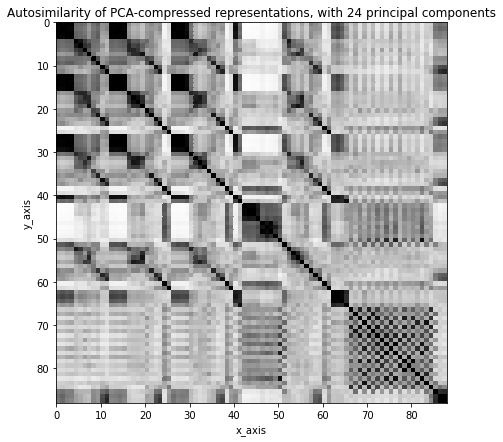

In [11]:
pca_projection = lra.get_pca_projection(nnlms, dc, bars, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)
#pca_projection = lra.pca_projection(barwise_TF_matrix, compression_dimension = dc) # Equivalent, but based on the Barwise TF matrix.

autosimilarity_pca = as_comp.get_cosine_autosimilarity(pca_projection)
plot_me_this_spectrogram(autosimilarity_pca, title = f"Autosimilarity of PCA-compressed representations, with {dc} principal components")

In [12]:
segments_pca = CBM.compute_cbm(autosimilarity_pca, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_pca_in_time = dm.segments_from_bar_to_time(segments_pca, bars)

score_pca_zero_five = dm.compute_score_of_segmentation(references_segments, segments_pca_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_pca_zero_five[0]}, Recall {score_pca_zero_five[1]}, F measure {score_pca_zero_five[2]}")
score_pca_three = dm.compute_score_of_segmentation(references_segments, segments_pca_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_pca_three[0]}, Recall {score_pca_three[1]}, F measure {score_pca_three[2]}")

Score with 0.5 second tolerance: Precision 0.46153846153846156, Recall 1.0, F measure 0.631578947368421
Score with 3 seconds tolerance: Precision 0.46153846153846156, Recall 1.0, F measure 0.631578947368421


## NMF

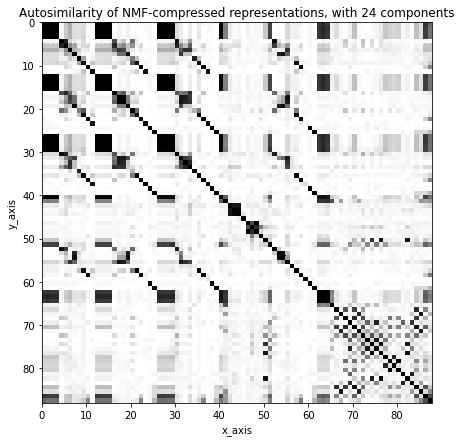

In [13]:
nmf_projection = lra.get_nmf_projection(nnlms, dc, bars, beta = 2, init = "nndsvd", subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

autosimilarity_nmf = as_comp.get_cosine_autosimilarity(nmf_projection)
plot_me_this_spectrogram(autosimilarity_nmf,title = f"Autosimilarity of NMF-compressed representations, with {dc} components")

In [14]:
segments_nmf = CBM.compute_cbm(autosimilarity_nmf, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_nmf_in_time = dm.segments_from_bar_to_time(segments_nmf, bars)

score_nmf_zero_five = dm.compute_score_of_segmentation(references_segments, segments_nmf_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_nmf_zero_five[0]}, Recall {score_nmf_zero_five[1]}, F measure {score_nmf_zero_five[2]}")
score_nmf_three = dm.compute_score_of_segmentation(references_segments, segments_nmf_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_nmf_three[0]}, Recall {score_nmf_three[1]}, F measure {score_nmf_three[2]}")

Score with 0.5 second tolerance: Precision 0.36, Recall 0.75, F measure 0.48648648648648657
Score with 3 seconds tolerance: Precision 0.36, Recall 0.75, F measure 0.48648648648648657


## AE

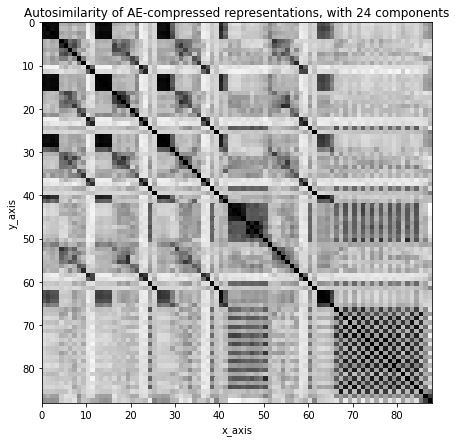

In [15]:
ae_projection = ae.get_conv_ssae_projection(nnlms, dc, bars, n_epochs = 1000, lr = 1e-3, subdivision_bars = subdivision_bars, hop_length = hop_length, sampling_rate = sampling_rate)

autosimilarity_ae = as_comp.get_cosine_autosimilarity(ae_projection)
plot_me_this_spectrogram(autosimilarity_ae,title = f"Autosimilarity of AE-compressed representations, with {dc} components")

In [16]:
segments_ae = CBM.compute_cbm(autosimilarity_ae, penalty_weight = 1, penalty_func = "modulo8", bands_number = 7)[0]
segments_ae_in_time = dm.segments_from_bar_to_time(segments_ae, bars)

score_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_ae_zero_five[0]}, Recall {score_ae_zero_five[1]}, F measure {score_ae_zero_five[2]}")
score_ae_three = dm.compute_score_of_segmentation(references_segments, segments_ae_in_time, window_length = 3)
print(f"Score with 3 seconds tolerance: Precision {score_ae_three[0]}, Recall {score_ae_three[1]}, F measure {score_ae_three[2]}")

Score with 0.5 second tolerance: Precision 0.3793103448275862, Recall 0.9166666666666666, F measure 0.5365853658536586
Score with 3 seconds tolerance: Precision 0.3793103448275862, Recall 0.9166666666666666, F measure 0.5365853658536586


# Conclusion
We've presented a tutorial for autoencoding songs, and evaluates the resulting latent projection in the structural segmentation task.

This code could, theoretically, be used for any song and any feature, modulo some adjustements in the code.

Finally, as a test conclusion, let's compare the results on the above features:

In [17]:
import pandas as pd
columns = np.array(["Precision 0.5", "Recall 0.5", "F measure 0.5","Precision 3", "Recall 3", "F measure 3"])  
tab = []
tab.append([round(score_barwise_tf_zero_five[0],5), round(score_barwise_tf_zero_five[1],5),round(score_barwise_tf_zero_five[2],5),round(score_barwise_tf_three[0],5),round(score_barwise_tf_three[1],5),round(score_barwise_tf_three[2],5)])
tab.append([round(score_ntd_zero_five[0],5), round(score_ntd_zero_five[1],5),round(score_ntd_zero_five[2],5),round(score_ntd_three[0],5),round(score_ntd_three[1],5),round(score_ntd_three[2],5)])
tab.append([round(score_pca_zero_five[0],5), round(score_pca_zero_five[1],5),round(score_pca_zero_five[2],5),round(score_pca_three[0],5),round(score_pca_three[1],5),round(score_pca_three[2],5)])
tab.append([round(score_nmf_zero_five[0],5), round(score_nmf_zero_five[1],5),round(score_nmf_zero_five[2],5),round(score_nmf_three[0],5),round(score_nmf_three[1],5),round(score_nmf_three[2],5)])
tab.append([round(score_ae_zero_five[0],5), round(score_ae_zero_five[1],5),round(score_ae_zero_five[2],5),round(score_ae_three[0],5),round(score_ae_three[1],5),round(score_ae_three[2],5)])

display(pd.DataFrame(tab, index=["Barwise TF", "NTD", "PCA", "NMF", "AE"], columns=columns))

,Precision 0.5,Recall 0.5,F measure 0.5,Precision 3,Recall 3,F measure 3
Barwise TF,0.42857,0.50000,0.46154,0.42857,0.50000,0.46154
NTD,0.40909,0.75000,0.52941,0.40909,0.75000,0.52941
PCA,0.46154,1.00000,0.63158,0.46154,1.00000,0.63158
NMF,0.36000,0.75000,0.48649,0.36000,0.75000,0.48649
AE,0.37931,0.91667,0.53659,0.37931,0.91667,0.53659
